In [52]:
!pip install bpemb

In [0]:
import numpy as np
import torchtext
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext import data
from torchtext.datasets import WikiText2
from bpemb import BPEmb
from torchtext.vocab import Vectors
from tqdm import tqdm
from torch.autograd import Variable as V

**Работа с данными, для токенизации будем использовать byte-pair-encoding**

In [54]:
bpemb_en = BPEmb(lang="en", dim=300, vs=3000)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [55]:
bpemb_en.encode('Machine learning') #the example of segmentation, subwords 

['▁mach', 'ine', '▁le', 'ar', 'ning']

In [56]:
bpemb_en.emb.save_word2vec_format('bpe_emv.vec') 

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
vec = Vectors(name='bpe_emv.vec', cache='./')

In [0]:
TEXT = data.Field(lower=True, tokenize=bpemb_en.encode)

In [0]:
train, validation, test = WikiText2.splits(TEXT)

In [0]:
TEXT.build_vocab(train, vectors = vec)

In [0]:
train_iter, validation_iter, test_iter = data.BPTTIterator.splits((train, validation, test),
                                                                  batch_size=32,
                                                                  bptt_len=30,
                                                                  device='cuda',
                                                                  repeat=False)

In [0]:
batch = next(iter(train_iter))

In [63]:
batch.text[:2]

tensor([[  17,   33,    4,    6,   56, 1874,  787,  686,   98,  291,    7,  331,
           62,  429,  127,  578,   24,   24, 1198,   22,  181,   13,    2, 1006,
           21,  384,  176,   36,   14,  120, 1417,    6],
        [  18,  268,   13,   10,   30,   19,   99,  326,   34,    5,    2,    2,
          685,  992,   23,   14,    5,  697,  575,  725,   68,   26,  180,   36,
          124,  133,    3,    4,   67,   49,    4,   10]], device='cuda:0')

In [64]:
batch.target[:2]

tensor([[  18,  268,   13,   10,   30,   19,   99,  326,   34,    5,    2,    2,
          685,  992,   23,   14,    5,  697,  575,  725,   68,   26,  180,   36,
          124,  133,    3,    4,   67,   49,    4,   10],
        [1128,  254,   26,  134,    2,   11,  327,   29,  578,   17,  540,  239,
          392,  454,  121, 1949,  163,   21,    2,   31,  842,   13, 1803,   77,
           17, 1238,  283,    9,    4, 1942,   13,    5]], device='cuda:0')

**Обучение RNN модели**

In [0]:
class RNNModel(nn.Module):
    def __init__(self, ntoken, ninp, nhid, nlayers, bsz, dropout=0.5, tie_weights=True):
        super(RNNModel, self).__init__()
        self.nhid, self.nlayers, self.bsz = nhid, nlayers, bsz
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)
        self.init_weights()
        self.hidden = self.init_hidden(bsz) 

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input):
        emb = self.drop(self.encoder(input))
        output, self.hidden = self.rnn(emb, self.hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1))

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        return (V(weight.new(self.nlayers, bsz, self.nhid).zero_().cuda()),
                V(weight.new(self.nlayers, bsz, self.nhid).zero_()).cuda())
    
    def reset_history(self):
        """Wraps hidden states in new Variables, to detach them from their history."""
        self.hidden = tuple(V(v.data) for v in self.hidden)

In [0]:
wt_mx = TEXT.vocab.vectors

In [0]:
model = RNNModel(wt_mx.shape[0], wt_mx.shape[1], 300, 2, 32)

In [68]:
model.encoder.weight.data.copy_(wt_mx)

tensor([[-0.2843,  0.0555,  0.5626,  ...,  0.1437,  0.1979, -0.0768],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1435, -0.0360, -0.1986,  ...,  0.0687, -0.1254,  0.1674],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [69]:
def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
number_of_parameters(model)

3240588

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, betas=(0.7, 0.99))

In [0]:
model = model.cuda()
criterion =criterion.cuda()

In [0]:
n_epochs = 5

In [0]:
n_tokens = wt_mx.shape[0]

In [74]:
n_tokens

2988

In [0]:
validation_loss = []
train_loss = []

def train_epoch(epoch, validation_loss, train_loss):
    model.train()
    progress_bar = tqdm(total=len(train_iter), disable=not True, desc='Train')
    for batch in train_iter:
        model.reset_history()
        optimizer.zero_grad()
  
        text, targets = batch.text, batch.target
        prediction = model(text)
    
        loss = criterion(prediction.view(-1, n_tokens), targets.view(-1))
        loss.backward()
        
        optimizer.step()
        l = loss.data.cpu().numpy()
        train_loss.append(l)
        progress_bar.set_postfix(loss=np.mean(train_loss[-150:]), perplexity=np.exp(np.mean(train_loss[-150:])))
        progress_bar.update()
        
    with torch.no_grad():
      val_loss = 0
      model.eval()
      for batch in validation_iter:
          model.reset_history()
          text, targets = batch.text, batch.target
          prediction = model(text)
          loss = criterion(prediction.view(-1, n_tokens), targets.view(-1))
          lv = loss.data.cpu().numpy()
          validation_loss.append(lv)
          val_loss += lv*text.shape[0]
          
      val_loss /= len(validation.examples[0].text)
    
    print('\nValidation Loss: {:.4f}'.format(val_loss)) 

In [76]:
for epoch in range(1, n_epochs + 1):
    print('\nEpoch:{}'.format(epoch))
    train_epoch(epoch, validation_loss, train_loss)
    for instance in list(tqdm._instances):
      tqdm._decr_instances(instance)

Train:   0%|          | 0/3426 [00:00<?, ?it/s]


Epoch:1


Train:   0%|          | 0/3426 [00:00<?, ?it/s]


Validation Loss: 0.1290

Epoch:2


Train:   0%|          | 0/3426 [00:00<?, ?it/s]


Validation Loss: 0.1194

Epoch:3


Train:   0%|          | 0/3426 [00:00<?, ?it/s]


Validation Loss: 0.1147

Epoch:4


Train:   0%|          | 0/3426 [00:00<?, ?it/s]


Validation Loss: 0.1119

Epoch:5


Train: 100%|██████████| 3426/3426 [01:21<00:00, 42.24it/s, loss=4.15, perplexity=63.6]


Validation Loss: 0.1101


In [0]:
for i in list(tqdm._instances):
      tqdm._decr_instances(i)

No handles with labels found to put in legend.


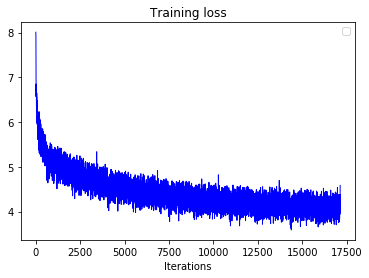

In [78]:
plt.title('Training loss')
plt.plot(train_loss, color='blue', linewidth=1)
plt.legend()
plt.xlabel('Iterations')
plt.show()

No handles with labels found to put in legend.


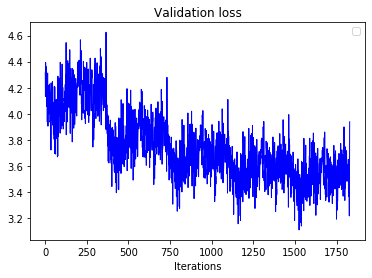

In [79]:
plt.title('Validation loss')
plt.plot(validation_loss, color='blue', linewidth=1)
plt.legend()
plt.xlabel('Iterations')
plt.show()

In [0]:
for i in list(tqdm._instances):
    tqdm._decr_instances(i)

In [0]:
batch = next(iter(test_iter))

In [0]:
def word_ids_to_sentence(id_tensor, vocab,join=None):
    if isinstance(id_tensor, torch.LongTensor):
        ids = id_tensor.transpose(0, 1).contiguous().view(-1)
    elif isinstance(id_tensor, np.ndarray):
        ids = id_tensor.transpose().reshape(-1)

    batch = [vocab.itos[ind] for ind in ids]
    if join is None:
        return batch
    else:
        return join.join(batch)

In [0]:
seed = batch.text[:, 1].unsqueeze(1)

In [84]:
word_ids_to_sentence(seed.cpu().data, TEXT.vocab, join='')

'ction▁delivered▁a▁performance▁of▁"▁kiss▁you▁"▁,▁in▁front▁of▁a▁video▁game▁@-@▁themed▁set▁,▁on▁the▁final'

In [0]:
seed = batch.text[:25, 2].unsqueeze(1)

In [0]:
def generate(seed, temp=1, max_sequence=20):
    t = torch.nn.Softmax(-1)
    seed = seed.cuda()
    model.eval()

    with torch.no_grad():

        emb = model.encoder(seed)     
        output, mem = model.rnn(emb)
        decoded = model.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        decoded = decoded.view(output.size(0), output.size(1), decoded.size(1))
        current_token = seed[-1,:].unsqueeze(1)
        
        pred = []

        for timestamp in range(max_sequence):

            emb = model.encoder(current_token)
            output, mem = model.rnn(emb, mem)
            decoded = model.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
            decoded = decoded.view(output.size(0), output.size(1), decoded.size(1))
            decoded = t(decoded/temp)           
            pred.append(decoded)
 
            current_token = decoded.argmax(dim=2)
           
        pred_ = torch.cat(pred, dim=0)
        BS = pred

    tokens = pred_.argmax(dim=-1).detach().cpu().numpy()
    print(tokens.shape)
    print('Seed:', word_ids_to_sentence(seed.cpu(), TEXT.vocab, join=''))
    print('Model:', word_ids_to_sentence(tokens, TEXT.vocab, join=''))
    return BS

**Sampling from probabilty distribution with temperature**

In [87]:
temp =generate(seed)

(20, 1)
Seed: ▁raised▁in▁kalamazoo▁,▁michigan▁before▁his▁family▁moved▁to▁saginaw▁,▁michig
Model: an▁'s▁death▁.<eos><eos>▁=▁=▁=▁=▁<unk>▁=▁=▁=<eos>


In [88]:
temp = generate(seed, temp = 1e+3)

(20, 1)
Seed: ▁raised▁in▁kalamazoo▁,▁michigan▁before▁his▁family▁moved▁to▁saginaw▁,▁michig
Model: an▁'s▁death▁.<eos><eos>▁=▁=▁=▁=▁<unk>▁=▁=▁=<eos>


In [89]:
temp = generate(seed, temp = 2e+5)

(20, 1)
Seed: ▁raised▁in▁kalamazoo▁,▁michigan▁before▁his▁family▁moved▁to▁saginaw▁,▁michig
Model: an▁'s▁death▁.<eos><eos>▁=▁=▁=▁=▁<unk>▁=▁=▁=<eos>


In [90]:
temp = generate(seed, temp = 3e+7)

(20, 1)
Seed: ▁raised▁in▁kalamazoo▁,▁michigan▁before▁his▁family▁moved▁to▁saginaw▁,▁michig
Model: i▁'s▁previous▁life▁to▁take▁a▁0▁–▁0▁defeate▁for▁a▁half▁of▁00▁:▁0
